In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import plotly.figure_factory as ff
import plotly.offline as py
import seaborn as sns

mpl.rcParams["figure.dpi"] = 300
plt.rcParams.update({'font.size': 22})
mpl.rcParams['xtick.labelsize']=14
mpl.rcParams['ytick.labelsize']=14
py.init_notebook_mode(connected=False)
mpl.rcParams["figure.dpi"] = 300
%matplotlib inline
%config InlineBackend.figure_format ='retina'

# Covid-19: The Second Wave In Singapore

Singapore's battle against the novel coronavirus entered a new phase around March 10, when the number of imported cases began to spike sharply. This notebooks takes a closer look at how the first and second wave of the Covid-19 outbreak differ.


## DATA SOURCE AND CAVEATS 

* This post covers 732 confirmed cases (415 imported, 317 local) announced by the Singapore authorities between January 23 and March 27. Data for the charts were compiled from daily Covid-19 updates on the health ministry's [website](https://www.moh.gov.sg/news-highlights/).


* The ministry's daily updates include Covid-19 cases confirmed on the day of the announcement, as well as those who tested positive a day earlier. For example, the press release dated March 27 would have patients who tested positive on both March 27 and March 26.


* To avoid confusion, the charts in this post will only use the dates for official confirmation of infection. These confirmation dates are medical records which will be more reliable and consistent going forward, compared to announcement dates which are more administrative in nature.


* Do note, however, that media reports in Singapore are based on new Covid-19 figures announced by the Government on a daily basis. There will be discrepancies if you compare the numbers reported in those articles with those highlighted in the charts here, as they take reference from different dates.


* Finally, a disclaimer: This is **not** a medical study. It is an attempt to better understand the underlying trends in publicly available information. Extra care has been taken to avoid over-interpreting the incomplete Covid-19 data.


* More background in this [post](https://www.analytix-labs.com/insights/covid19-second-wave)

# 1. DATA PRE-PROCESSING; MINOR FEATURE ENGINEERING

In [2]:
raw = pd.read_csv('../data/covidsg_2ndwave.csv')

In [3]:
# extracting month/day for slicing in later sections
# dates were recorded in day/month/year format, hence dayfirst=True

raw["Confirmed Date"] = pd.to_datetime(
    raw["Date Confirmed Positive"], dayfirst=True
).dt.date

# converting date cols to datetime;
raw["Month"] = pd.to_datetime(raw["Confirmed Date"], dayfirst=True).dt.month
raw["Day"] = pd.to_datetime(raw["Confirmed Date"], dayfirst=True).dt.day


In [4]:
# Creating age-ranges for ease of comparisons during visualisation
raw["0-9"] = np.where(raw["Age"] < 10, "Ages 0-9", "")

raw["10-19"] = np.where(
    ((raw["Age"] >= 10) & (raw["Age"] < 20)), "Ages 10-19", ""
)

raw["20-29"] = np.where(
    ((raw["Age"] >= 20) & (raw["Age"] < 30)), "Ages 20-29", ""
)

raw["30-39"] = np.where(
    ((raw["Age"] >= 30) & (raw["Age"] < 40)), "Ages 30-39", ""
)

raw["40-49"] = np.where(
    ((raw["Age"] >= 40) & (raw["Age"] < 50)), "Ages 40-49", ""
)

raw["50-59"] = np.where(
    ((raw["Age"] >= 50) & (raw["Age"] < 60)), "Ages 50-59", ""
)

raw["60-69"] = np.where(
    ((raw["Age"] >= 60) & (raw["Age"] < 70)), "Ages 60-69", ""
)

raw["70-79"] = np.where(
    ((raw["Age"] >= 70) & (raw["Age"] < 80)), "Ages 70-79", ""
)

raw["80-89"] = np.where(
    ((raw["Age"] >= 80) & (raw["Age"] < 90)), "Ages 80-89", ""
)

raw["Age Range"] = raw[
    [
        "0-9",
        "10-19",
        "20-29",
        "30-39",
        "40-49",
        "50-59",
        "60-69",
        "70-79",
        "80-89",
    ]
].apply("".join, axis=1)

raw = raw.drop(
    columns=[
        "0-9",
        "10-19",
        "20-29",
        "30-39",
        "40-49",
        "50-59",
        "60-69",
        "70-79",
        "80-89",
        "Date Confirmed Positive",
    ]
).copy()

In [5]:
# Refine column selection

cols = [
    "Confirmed Case ID",
    "Category",
    "Travel History",
    "Nationality",
    "Age",
    "Age Range",
    "Gender",
    "Confirmed Date",
    "Month",
    "Day"
]

raw = raw[cols].copy()


In [6]:
raw.head()

Confirmed Case ID  Category Travel History Nationality   Age   Age Range  \
0            Case 1  Imported          China       China  66.0  Ages 60-69   
1            Case 2  Imported          China       China  53.0  Ages 50-59   
2            Case 3  Imported          China       China  37.0  Ages 30-39   
3            Case 4  Imported          China       China  36.0  Ages 30-39   
4            Case 5  Imported          China       China  56.0  Ages 50-59   

  Gender Confirmed Date  Month  Day  
0      M     2020-01-23      1   23  
1      F     2020-01-24      1   24  
2      M     2020-01-24      1   24  
3      M     2020-01-25      1   25  
4      F     2020-01-27      1   27

# 2. IMPORT VS LOCAL

* First, I want to see how imported and local Covid-19 cases in Singapore have grown since Jan 23, and whether there is an obvious inflection point. Some additional data transformation is needed before we can plot the chart. 

In [7]:
local = raw[raw['Category'] == "Local"]

imported = raw[raw['Category'] == "Imported"]

In [8]:
# In our sample, there are 317 local cases and 415 imported ones.

local.shape, imported.shape

((317, 10), (415, 10))

In [9]:
# Creating 2 separate DFs for counts of local and imported cases

local_trend = local.groupby(["Confirmed Date"])["Category"].count()

local_trend = pd.DataFrame(
    local_trend.reset_index().rename(
        columns={"index": "Date", 0: "Local Cases Count"}
    )
)

local_trend.columns = ["Date", "Local Cases Count"]


imported_trend = imported.groupby(["Confirmed Date"])["Category"].count()

imported_trend = pd.DataFrame(
    imported_trend.reset_index().rename(
        columns={"index": "Date", 0: "Imported Cases Count"}
    )
)

imported_trend.columns = ["Date", "Imported Cases Count"]

In [10]:
# Concating the two DFs with counts of local/imported cases
# Filling NaN entries with 0 for those rare days where 0 import/local cases were recorded

second_wave = pd.merge(
    left=imported_trend, right=local_trend,
    on="Date",
    how="outer",
    sort=True,
)

second_wave = second_wave.fillna(0)

In [11]:
second_wave.head()

Date  Imported Cases Count  Local Cases Count
0  2020-01-23                   1.0                0.0
1  2020-01-24                   2.0                0.0
2  2020-01-25                   1.0                0.0
3  2020-01-27                   3.0                0.0
4  2020-01-28                   1.0                0.0

In [12]:
# This was used in Google for the chart below

# second_wave.to_csv('../data/second_wave.csv', index=False)

## NOTE:

* Due to time constraints, I plotted the chart below on Google Sheet and annotated on Google Slides. Feel free to do one via matplotlib or seaborn.

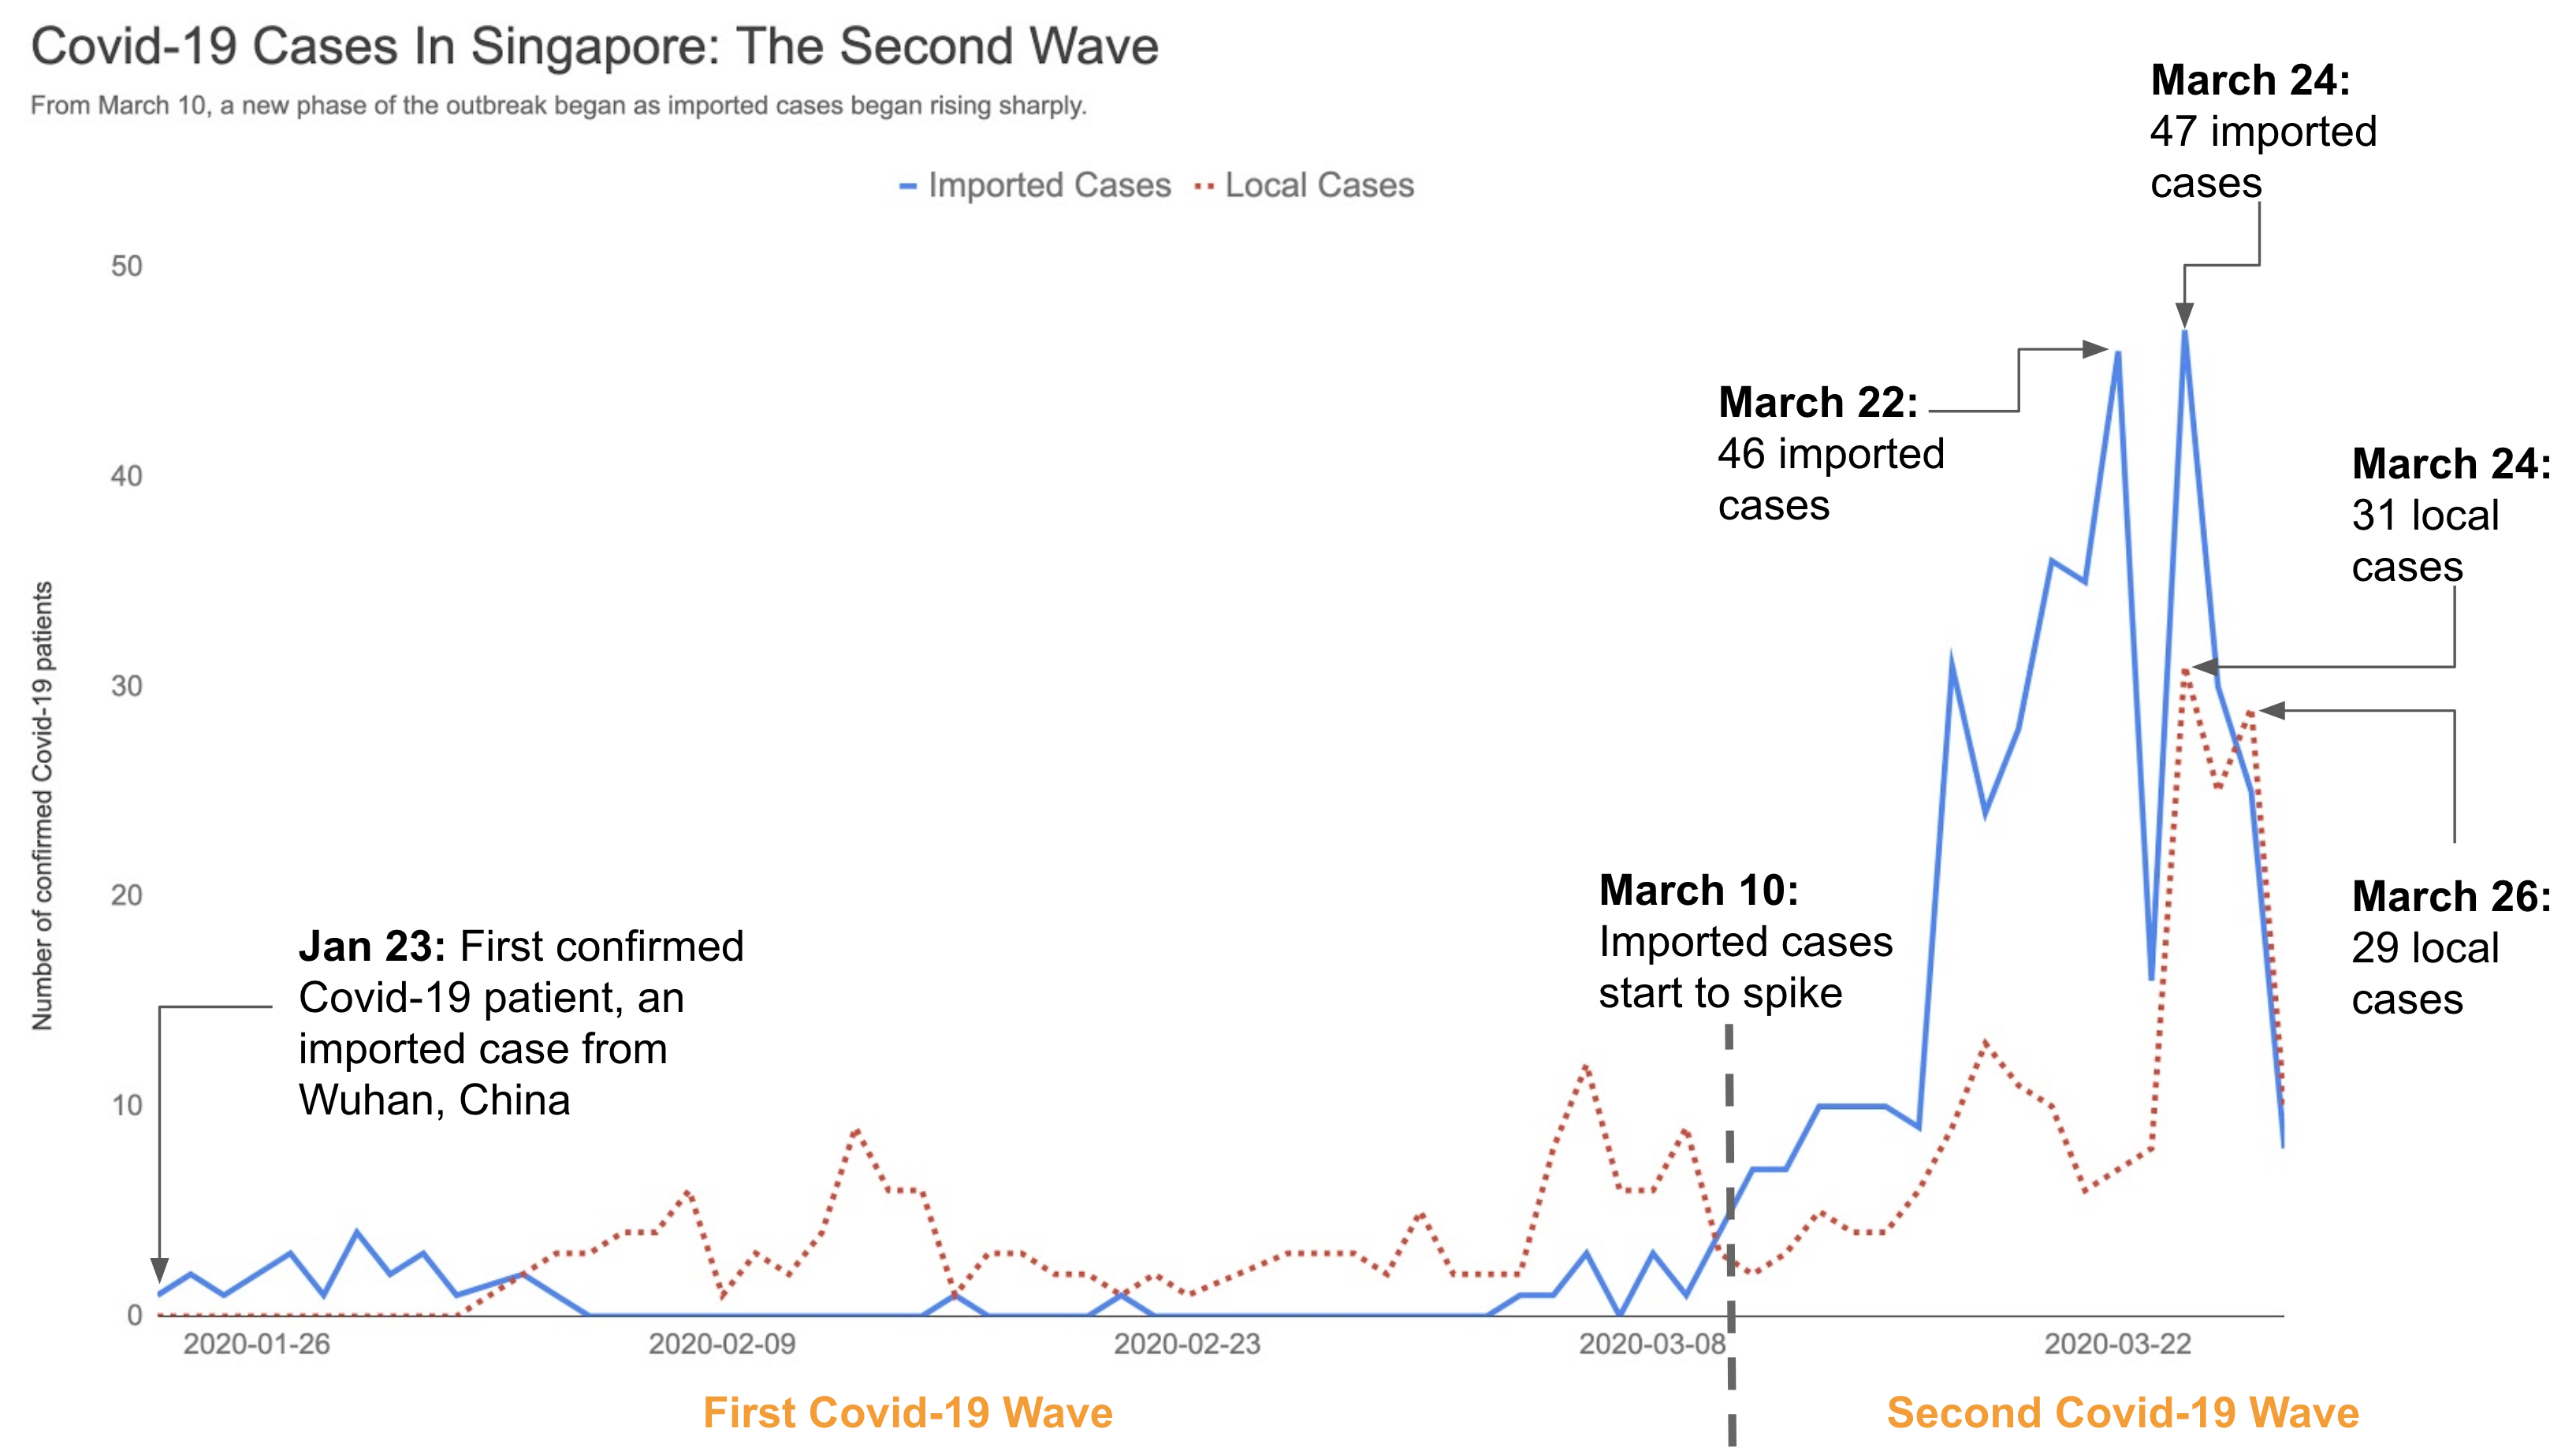

* There is obviously a lag between the onset of new infections and the authorities' ability to detect and confirm them. But based on the breakdown of available data, it would appear that Singapore's Covid-19 outbreak entered a new phase on or around March 10. That was when the number of imported cases began overtaking the locally transmitted ones - slowly at first, followed by a dramatic surge as seen in the chart below.


* Prior to March 10, the vast majority of imported cases involved travellers from mainland China or Singaporeans evacuated from Wuhan, the central Chinese city where the Covid-19 pandemic began.


* The first imported case that did not have a China connection- Patient 113 - was confirmed only on March 04, almost six weeks after Singapore reported its first Covid-19 case on January 23. [Patient 113](https://www.moh.gov.sg/news-highlights/details/two-more-cases-discharged-five-new-cases-of-covid-19-infection-confirmed), a 42-year-old French national who had travelled to France, Portugal, Turkey, and the UK, was a sign of things to come even as local cases continued to surpass imported ones for another six days.


* On March 10, the number of imported cases took a slight lead over local cases (four imported cases versus three local ones) for the first time in weeks . A week later on March 17, the number of imported cases spiked to 31. And a week after this on March 24, 47 imported cases were confirmed, the highest one-day record for such cases so far.

# 3. COMPARING PHASE 1 AND PHASE 2: KEY CHARACTERISTICS

* The numbers are changing fast, so there's not much point making very detailed plots that will be overtaken by events. I've broken down some key stats below out of curiosity. I'll briefly mention them in the Medium blog post instead of coming up with new charts.


* I loaded up a quick template on Flourish that would allow for a quick breakdown according to gender, age, nationalities etc. You can access it [here](https://public.flourish.studio/visualisation/1732543/). I don't intend to breakdown the numbers in great detail.

In [13]:
# Create a new col to indicate whether a case is in Phase 1 or 2

raw['Phase'] = np.where((raw["Month"] == 3) & (raw["Day"] >= 10), "Second Wave", "First Wave")

In [14]:
# CSV file used in Flourish template

# raw.to_csv('../data/phases1_2.csv', index=False)

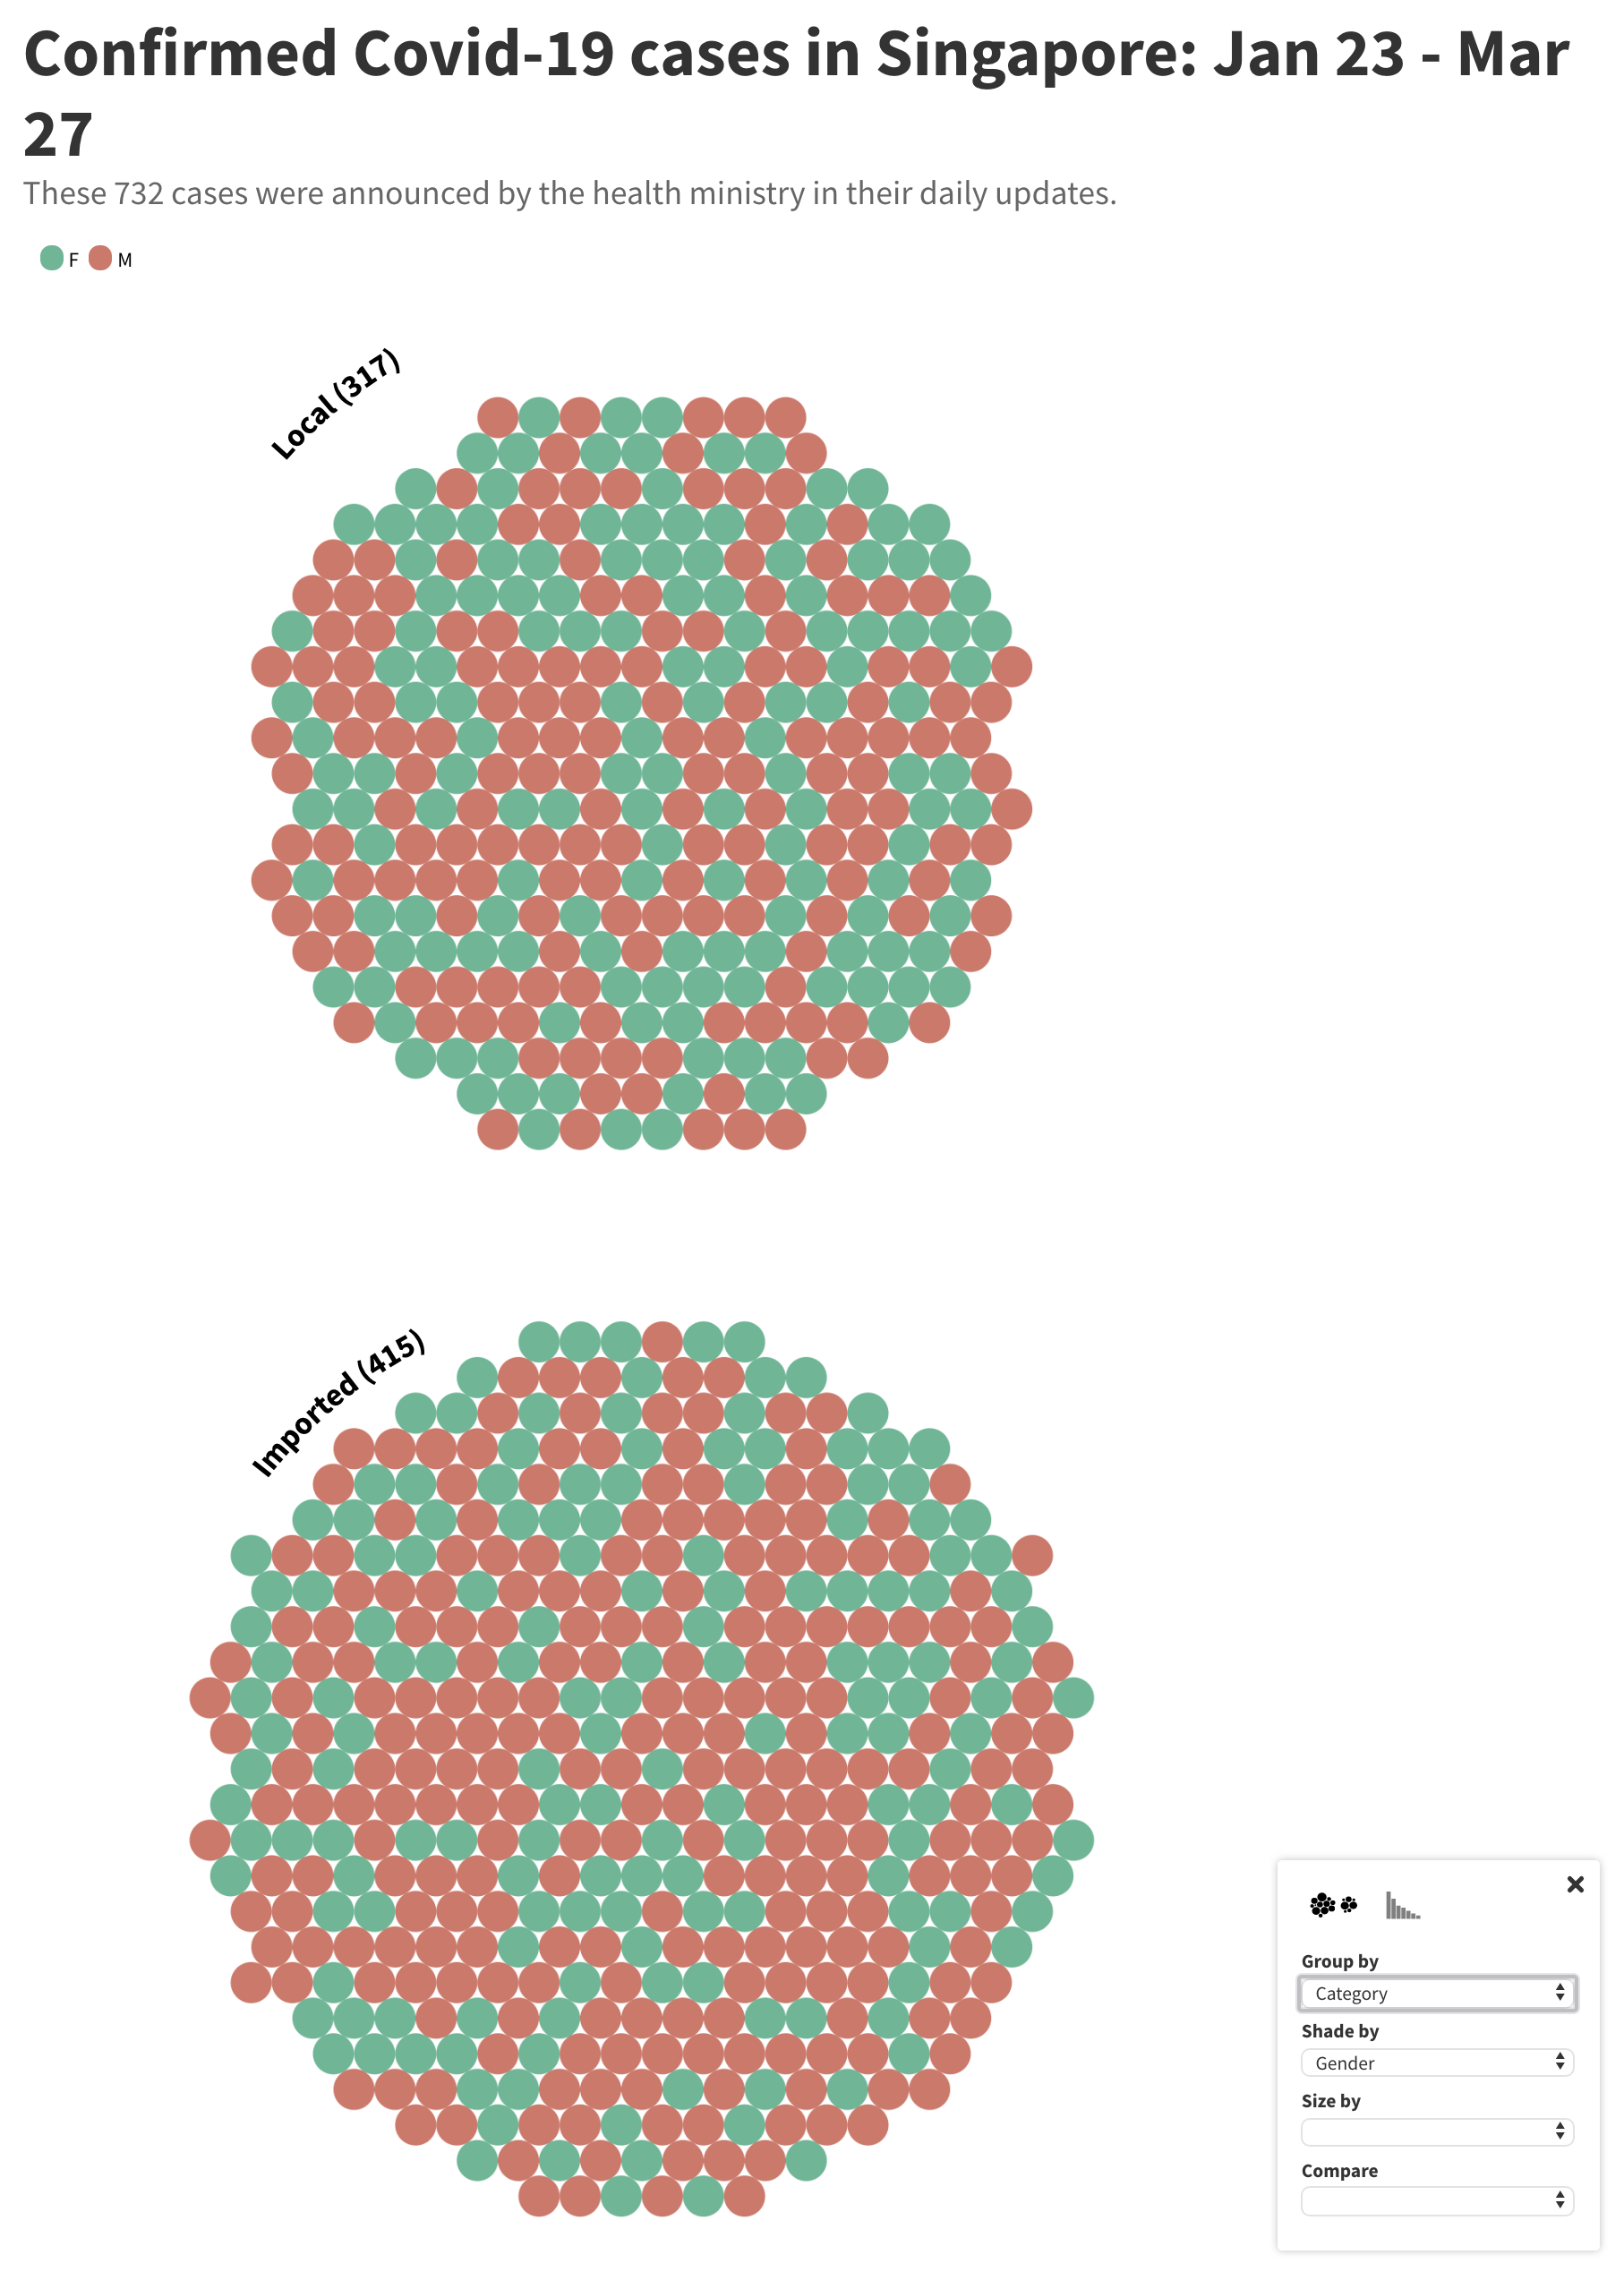

## 3.1 QUICK COMPARISON OF KEY DEMOGRAPHICS IN PHASE 1 AND 2

In [15]:
# More male confirmed Covid-19 patients than female in both phases

raw.groupby(['Phase'])['Gender'].value_counts()

Phase        Gender
First Wave   M          92
             F          71
Second Wave  M         328
             F         241
Name: Gender, dtype: int64

In [16]:
# Imported cases dominate in the second phase, as we have seen

raw.groupby(['Phase'])['Category'].value_counts()

Phase        Category
First Wave   Local       131
             Imported     32
Second Wave  Imported    383
             Local       186
Name: Category, dtype: int64

In [17]:
# Confirmed cases in the second phase has a far higher number of younger patients in the 20-29 age range
# This is likely due to the high number of returning students from the UK and US

raw.groupby(['Phase'])['Age Range'].value_counts()

Phase        Age Range 
First Wave   Ages 50-59     38
             Ages 30-39     35
             Ages 60-69     29
             Ages 40-49     28
             Ages 20-29     17
             Ages 70-79     10
             Ages 0-9        4
             Ages 10-19      2
Second Wave  Ages 20-29    179
             Ages 30-39    101
             Ages 50-59     86
             Ages 40-49     82
             Ages 60-69     64
             Ages 10-19     23
             Ages 70-79     22
             Ages 0-9        6
             Ages 80-89      6
Name: Age Range, dtype: int64

In [18]:
# A further breakdown confirms this: the larger number of young confirmed cases in Phase 2 are likely returning students 

raw.groupby(['Phase', "Category"])['Age Range'].value_counts()

Phase        Category  Age Range 
First Wave   Imported  Ages 30-39     12
                       Ages 50-59      7
                       Ages 40-49      6
                       Ages 60-69      4
                       Ages 0-9        1
                       Ages 10-19      1
                       Ages 70-79      1
             Local     Ages 50-59     31
                       Ages 60-69     25
                       Ages 30-39     23
                       Ages 40-49     22
                       Ages 20-29     17
                       Ages 70-79      9
                       Ages 0-9        3
                       Ages 10-19      1
Second Wave  Imported  Ages 20-29    145
                       Ages 30-39     70
                       Ages 40-49     55
                       Ages 50-59     45
                       Ages 60-69     32
                       Ages 10-19     19
                       Ages 70-79     12
                       Ages 0-9        3
                       

In [19]:
age_breakdown = raw.groupby(['Phase', "Category", "Nationality"])['Age Range'].value_counts()

age_breakdown = pd.DataFrame(
    age_breakdown.rename(
        columns={"index": "Phase", 0: "Category", 1: "Nationality", 2:"Age Range", 3: "Count"}
    )
).reset_index()

age_breakdown.columns = ["Phase", "Category", "Nationality", "Age Range", "Count"]

In [20]:
# age_breakdown.to_csv('../data/age_breakdown.csv', index=False)

## 3.2 NATIONALITIES OF IMPORT VS LOCAL CASES

* What I'm really interested to find out is the split in nationalities between the import and local cases. But this is too unwieldly to chart, and various versions of charts I tried didn't turn out well.

* Still, a breakdown is interesting nonetheless. In the Second Wave, Singaporeans dominated the number of imported cases, reflecting the Government's challenge in managing the crisis going ahead. The challenge is no longer just about keeping out infected cases from a select number of sources, though that remains important.

* The more challenging task is two-fold: One is in managing the logistical nightmare involved in helping citizens return from Covid-19 hot zones, and the other more complex task is convincing its own people not to travel in the immediate future so as not to bring the disease back. The later presents tricky policy questions that would be debated for some time to come.

In [21]:
raw.groupby(['Phase', "Category"])['Nationality'].value_counts()

Phase        Category  Nationality 
First Wave   Imported  China            17
                       Singapore         8
                       Indonesia         2
                       Singapore PR      2
                       France            1
                       Italy             1
                       UK                1
             Local     Singapore       104
                       Singapore PR     11
                       Bangladesh        5
                       Malaysia          3
                       China             2
                       Philippines       2
                       Indonesia         1
                       Indonesian        1
                       Japan             1
                       Myanmar           1
Second Wave  Imported  Singapore       239
                       Singapore PR     34
                       UK               16
                       Indonesia        15
                       Australia        10
                  

# 4. TRAVEL HISTORY

* Next, let's examine the destinations the imported cases have travelled to/come from. I want to find out how many unique destinations are involved, which is the top source for imported cases, and whether there are major differences between Phase 1 and Phase 2.

## 4.1 NUMBER OF UNIQUE DESTINATIONS

In [22]:
destinations = raw["Travel History"].dropna().values.tolist()

destinations = [
    destination.strip() for item in destinations for destination in item.split(",")
]

destinations = list(set(destinations))


In [23]:
len(destinations)

45

In [24]:
destinations

['Sri Lanka',
 'Indonesia',
 'Italy',
 'Japan',
 'Germany',
 'Thailand',
 'UAE',
 'Sweden',
 'UK',
 'China',
 'Bosnia',
 'India',
 'Iceland',
 'Malaysia',
 'Spain',
 'France',
 'Ireland',
 'Asean',
 'Pakistan',
 'Holland',
 'Pending',
 'Australia',
 'US',
 'Europe',
 'Russia',
 'Slovenia',
 'Belgium',
 'Netherlands',
 'Eastern Europe',
 'Turkey',
 'Denmark',
 'Philippines',
 'Austria',
 'South Africa',
 'Taiwan',
 'Czech Republic',
 'Canada',
 'Norway',
 'Switzerland',
 'Hungary',
 'Mexico',
 'Croatia',
 'Monaco',
 'Portugal',
 'Serbia']

## NOTE: 

* At the time of writing, Singapore's 415 imported Covid-19 cases have travel histories involving 45 different destinations. However, the information released by the health ministry in this area has not been consistent, with the travel histories of some imported cases published as "Asean", "Europe" and "Eastern Europe" without elaboration. The ministry also flagged the travel histories of 19 imported cases as "Pending" without explaining why the information was not available.


* If we exclude these four problematic categories, the 41 countries where the imported Covid-19 cases have travelled to (or from) are: **UK, US, Indonesia, China, Philippines, Malaysia, France, Thailand, Spain, Italy, Slovenia, Monaco, Taiwan, Ireland, Turkey, United Arab Emirates, Canada, Australia, Bosnia, Norway, Japan, Russia, Iceland, Serbia, Hungary, Denmark, Switzerland, Pakistan, India, Holland, Sri Lanka, Austria, Belgium, Croatia, Mexico, Czech Republic, Portugal, Netherlands, South Africa, Germany, and Sweden.**

## 3.2 TOP TRAVEL DESTINATIONS FOR IMPORTED CASES

In [25]:
# UK is the top source for imported cases, by a mile
# But there are also cases with multiple destinations that include UK as a stop
# Singapore's health ministry does not make clear which destination an imported case
# likely got infected with Covid-19

imported['Travel History'].value_counts().head(20)

UK                                           136
US                                            47
Indonesia                                     29
China                                         23
Pending                                       19
Philippines                                   15
Europe                                        14
Malaysia                                      13
France                                        12
Thailand                                       7
Spain                                          6
India                                          5
Germany                                        3
Ireland                                        3
Asean                                          3
France, UK                                     3
Switzerland, UK                                2
Germany, Czech Republic, Austria, Hungary      2
Germany, Italy, Switzerland                    2
France, Switzerland                            2
Name: Travel History

In [26]:
# Find all imported cases with UK as part of travel itinerary

uk_travel = imported[imported['Travel History'].str.contains('UK')] 

In [27]:
# 155 imported cases had UK as part of their itinerary, prior to arriving in Singapore and testing positive

uk_travel.shape

(155, 10)

In [28]:
uk_travel['Nationality'].value_counts()

Singapore       113
Singapore PR     14
UK               10
France            3
India             3
Indonesia         2
Australia         2
Philippines       1
Brazil            1
Germany           1
Malaysia          1
Netherlands       1
New Zealand       1
US                1
Britain           1
Name: Nationality, dtype: int64

In [29]:
uk_travel['Age Range'].value_counts()

Ages 20-29    86
Ages 30-39    24
Ages 50-59    15
Ages 40-49    13
Ages 10-19    10
Ages 60-69     6
Ages 70-79     1
Name: Age Range, dtype: int64

In [30]:
uk_students = uk_travel[(uk_travel['Age'] >=18) & (uk_travel['Age'] <=25)]

uk_students.shape

(78, 10)

## NOTE:

* UK is top single destination from which imported cases travelled from, with 136 confirmed cases. Number of confirmed cases go up to 155 if we include patients who have multiple stops and had UK as one of the destinations.


* A breakdown of the 155 imported cases with a UK travel history showed that:
            
            * 113, or 73%, are Singaporeans, while 14 are Singapore permanent residents.
            
            * About half, or 78, are aged between 18 and 25.


* I'm going to **drop** the problematic entries with "Asean", "Europe", "Eastern Europe" and "Pending" from the overall ranking of top destinations. These entries are too vague and muddle the overall rankings of imported sources.  

In [31]:
# Create new DF that excludes rows with the 4 problematic entries for "Travel History"
single_origin = imported[
    (imported["Travel History"] != "Europe")
    & (imported["Travel History"] != "Eastern Europe")
    & (imported["Travel History"] != "Asean")
    & (imported["Travel History"] != "Pending")
]


In [32]:
# We unfortunately lose 38 rows as a result

single_origin.shape

(377, 10)

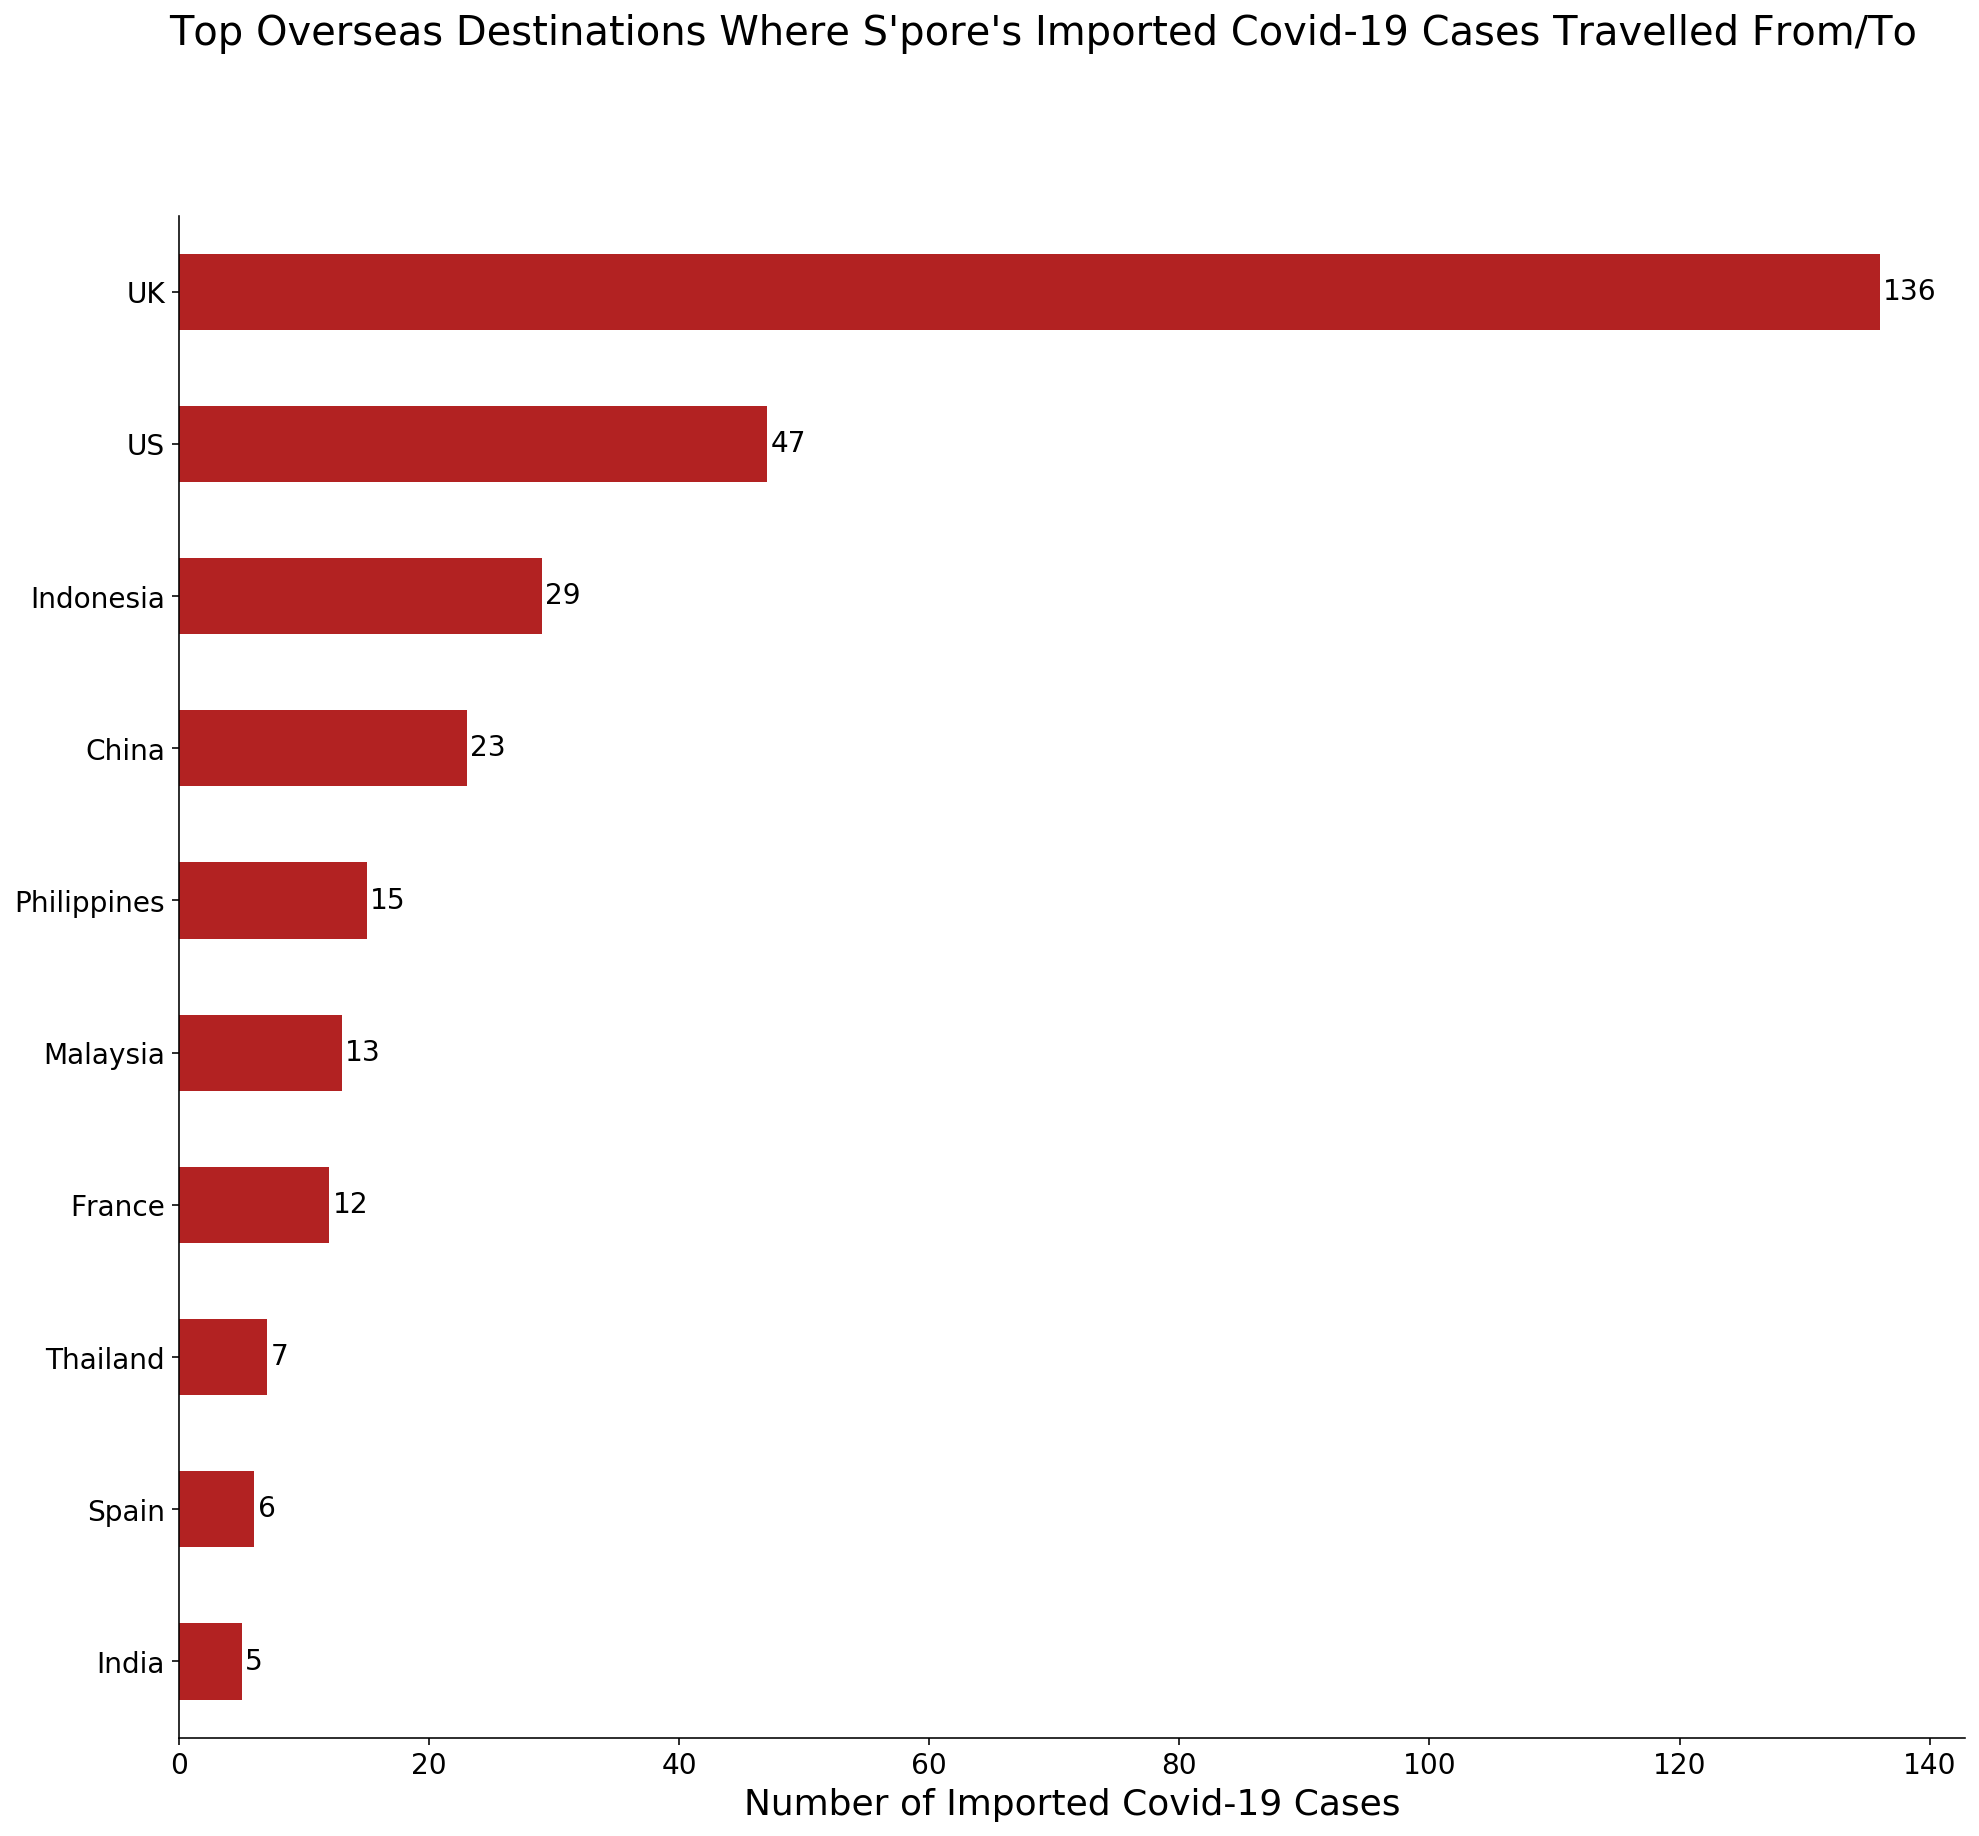

In [33]:
fig, ax = plt.subplots(figsize=(16, 14))

single_origin['Travel History'].value_counts().head(10).sort_values(ascending=True).plot(
    kind="barh", color="firebrick"
)

totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(
        i.get_width() + 0.3,
        i.get_y() + 0.2,
        str(round((i.get_width()))),
        fontsize=14,
        color="black",
    )

fig.suptitle(
    "Top Overseas Destinations Where S'pore's Imported Covid-19 Cases Travelled From/To", fontsize=20
)

plt.ylabel("", fontsize=18)
plt.xlabel("Number of Imported Covid-19 Cases", fontsize=18)

ax.grid(False)
sns.despine()
plt.show()

## 3.3 SOURCE OF IMPORTED CASES: 1ST WAVE VS 2ND WAVE

* Finally, I want to see the difference between the main sources for imported cases in Phase 1 (Jan 23 - March 09) Vs Phase 2 (March 10 onwards)

In [34]:
# Isloating imported cases from March 10 onwards

wave2 = single_origin[(single_origin["Month"] == 3) & (single_origin["Day"] >= 10)]


In [35]:
wave2['Travel History'].value_counts()

UK                              135
US                               47
Indonesia                        26
Philippines                      15
Malaysia                         13
                               ... 
Australia                         1
Switzerland, France               1
Italy, Switzerland                1
Denmark, Switzerland, France      1
France, Spain                     1
Name: Travel History, Length: 70, dtype: int64

In [36]:
# Isloating imported cases between Jan 23 and March 09

wave1 = single_origin[
    ~single_origin["Confirmed Case ID"].isin(wave2["Confirmed Case ID"].values)
]


In [37]:
wave1['Travel History'].value_counts()

China                   23
Indonesia                3
Germany                  1
Switzerland, UK          1
UK                       1
South Africa, France     1
France, Portugal, UK     1
US, Italy                1
Name: Travel History, dtype: int64

## 3.3.1 WAVE 1: TOP SOURCES FOR IMPORTED CASES; JAN 23 - MAR 09

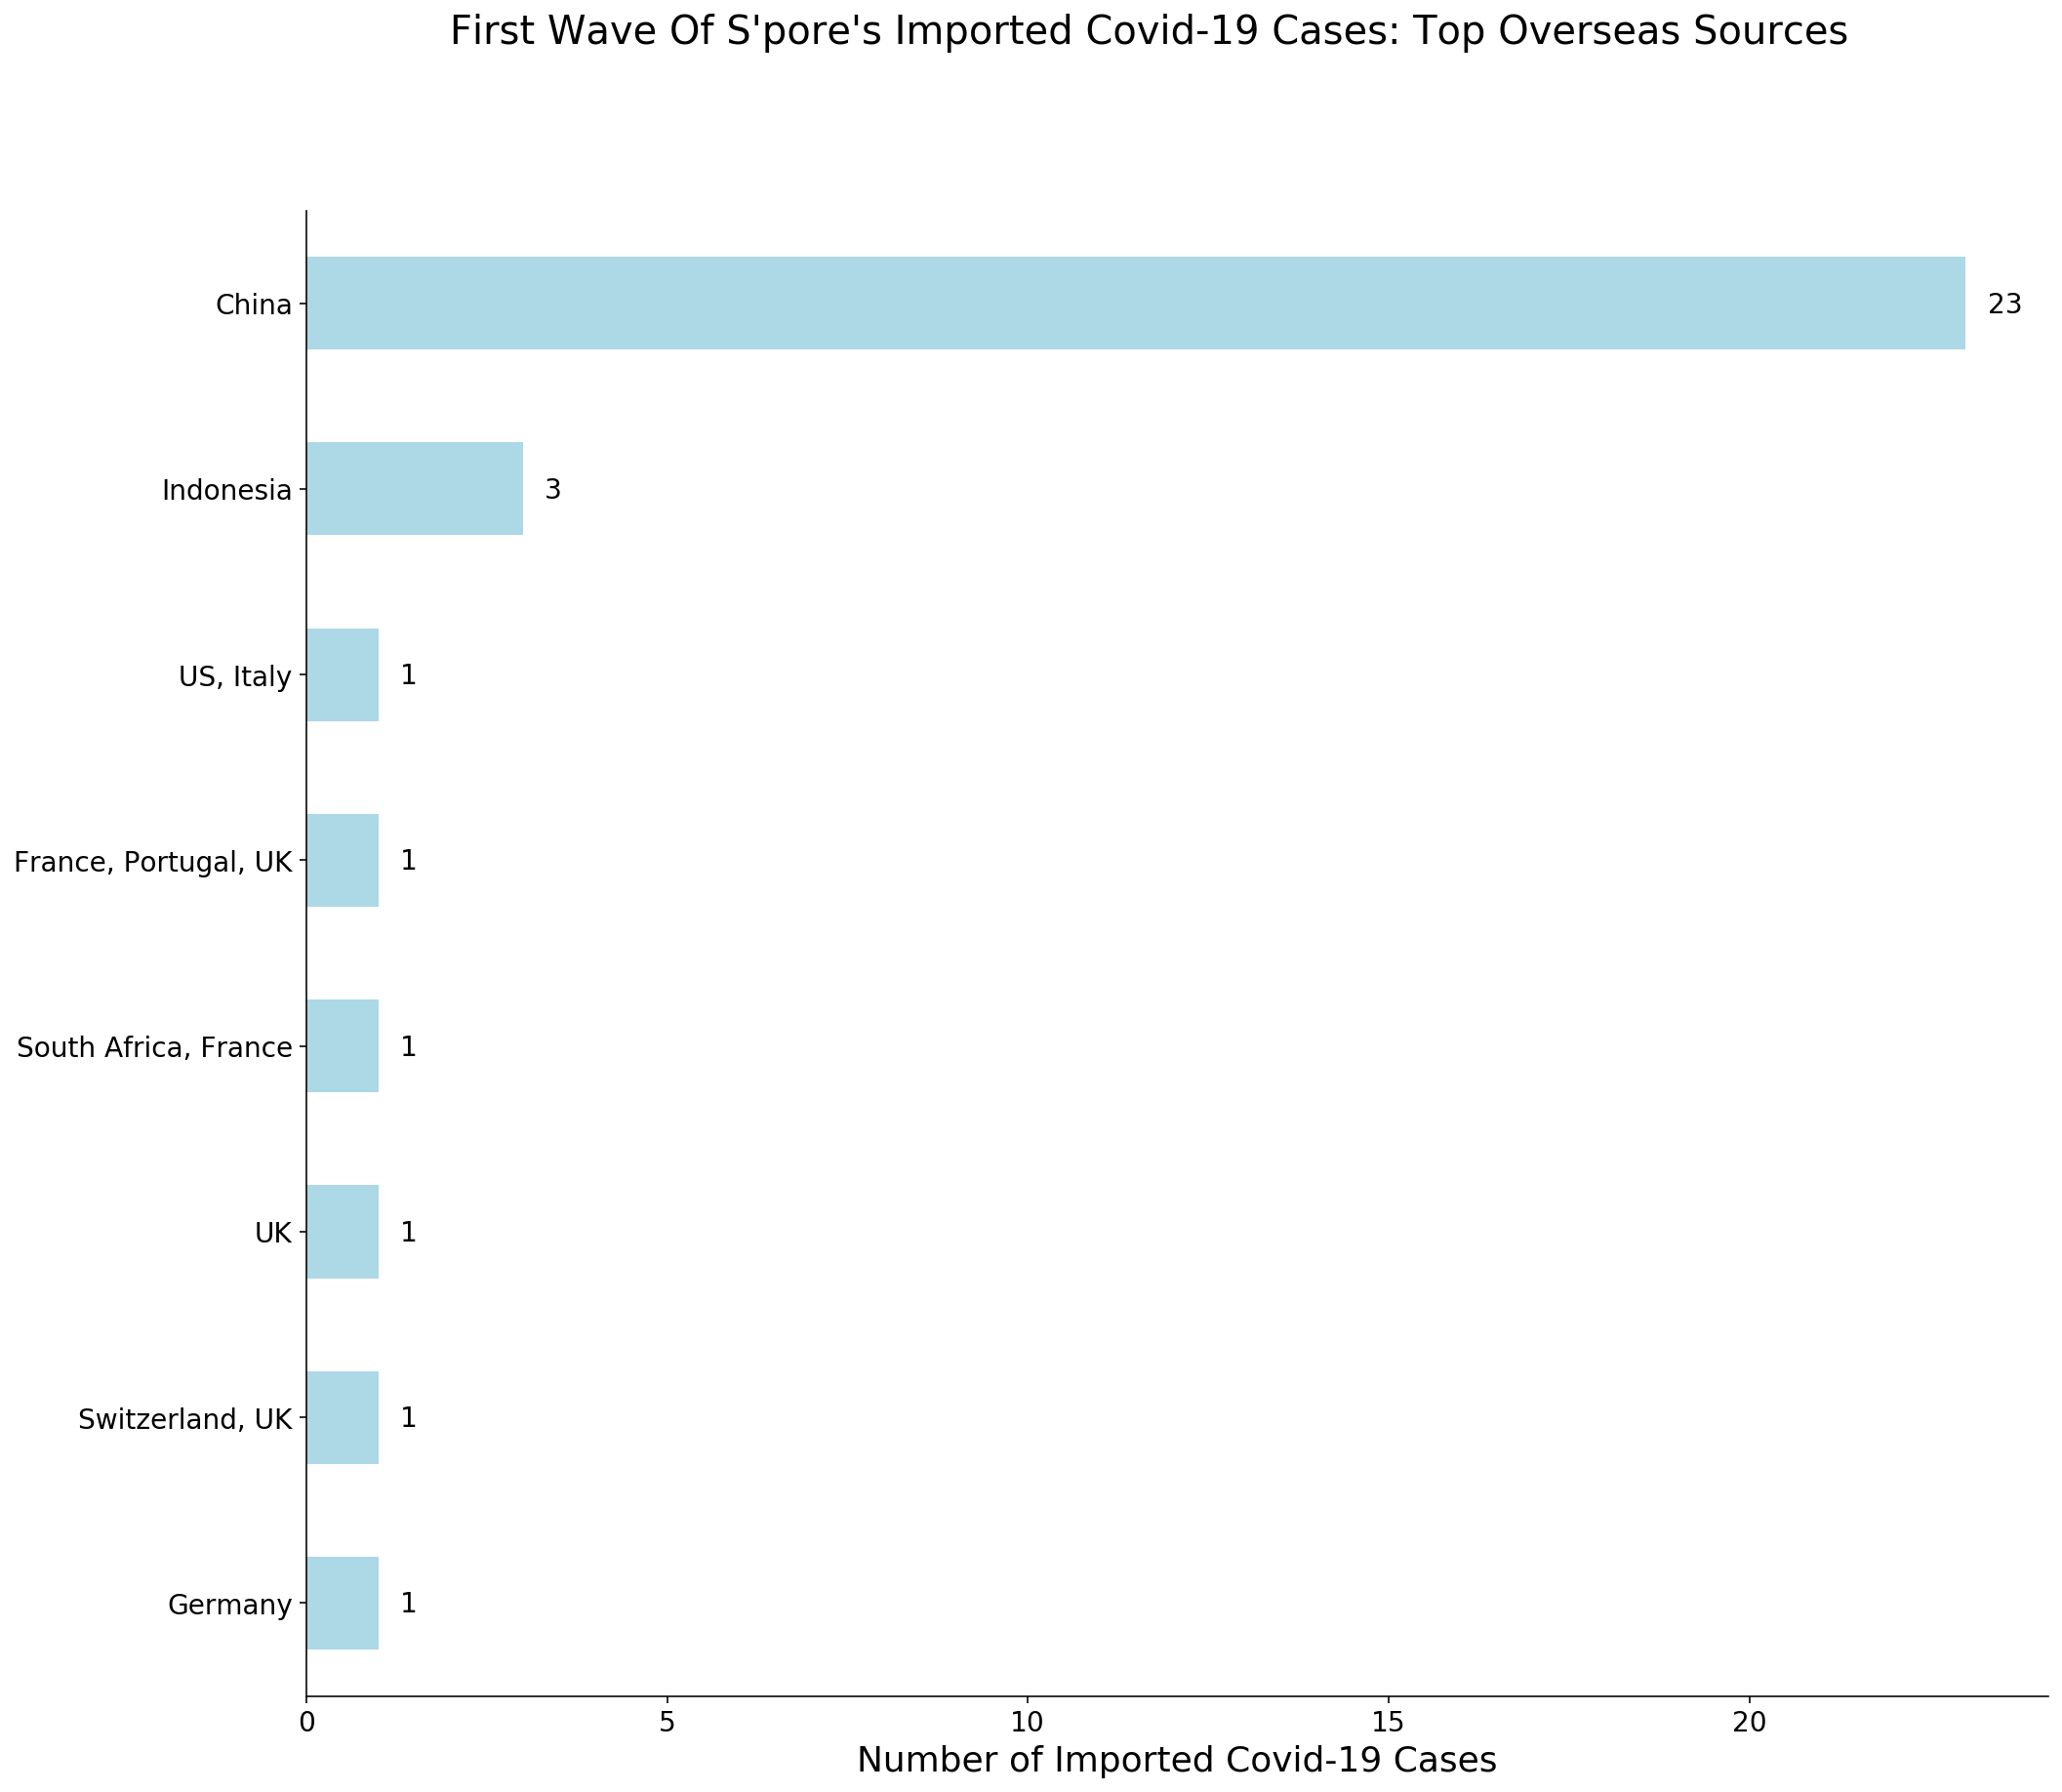

In [38]:
fig, ax = plt.subplots(figsize=(16, 14))

wave1['Travel History'].value_counts().sort_values(ascending=True).plot(
    kind="barh", color="lightblue"
)

totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(
        i.get_width() + 0.3,
        i.get_y() + 0.2,
        str(round((i.get_width()))),
        fontsize=14,
        color="black",
    )

fig.suptitle(
    "First Wave Of S'pore's Imported Covid-19 Cases: Top Overseas Sources", fontsize=20
)

plt.ylabel("", fontsize=18)
plt.xlabel("Number of Imported Covid-19 Cases", fontsize=18)

ax.grid(False)
sns.despine()
plt.show()

## 3.3.2 WAVE 2: TOP SOURCES FOR IMPORTED CASES; MAR 10 - MAR 27

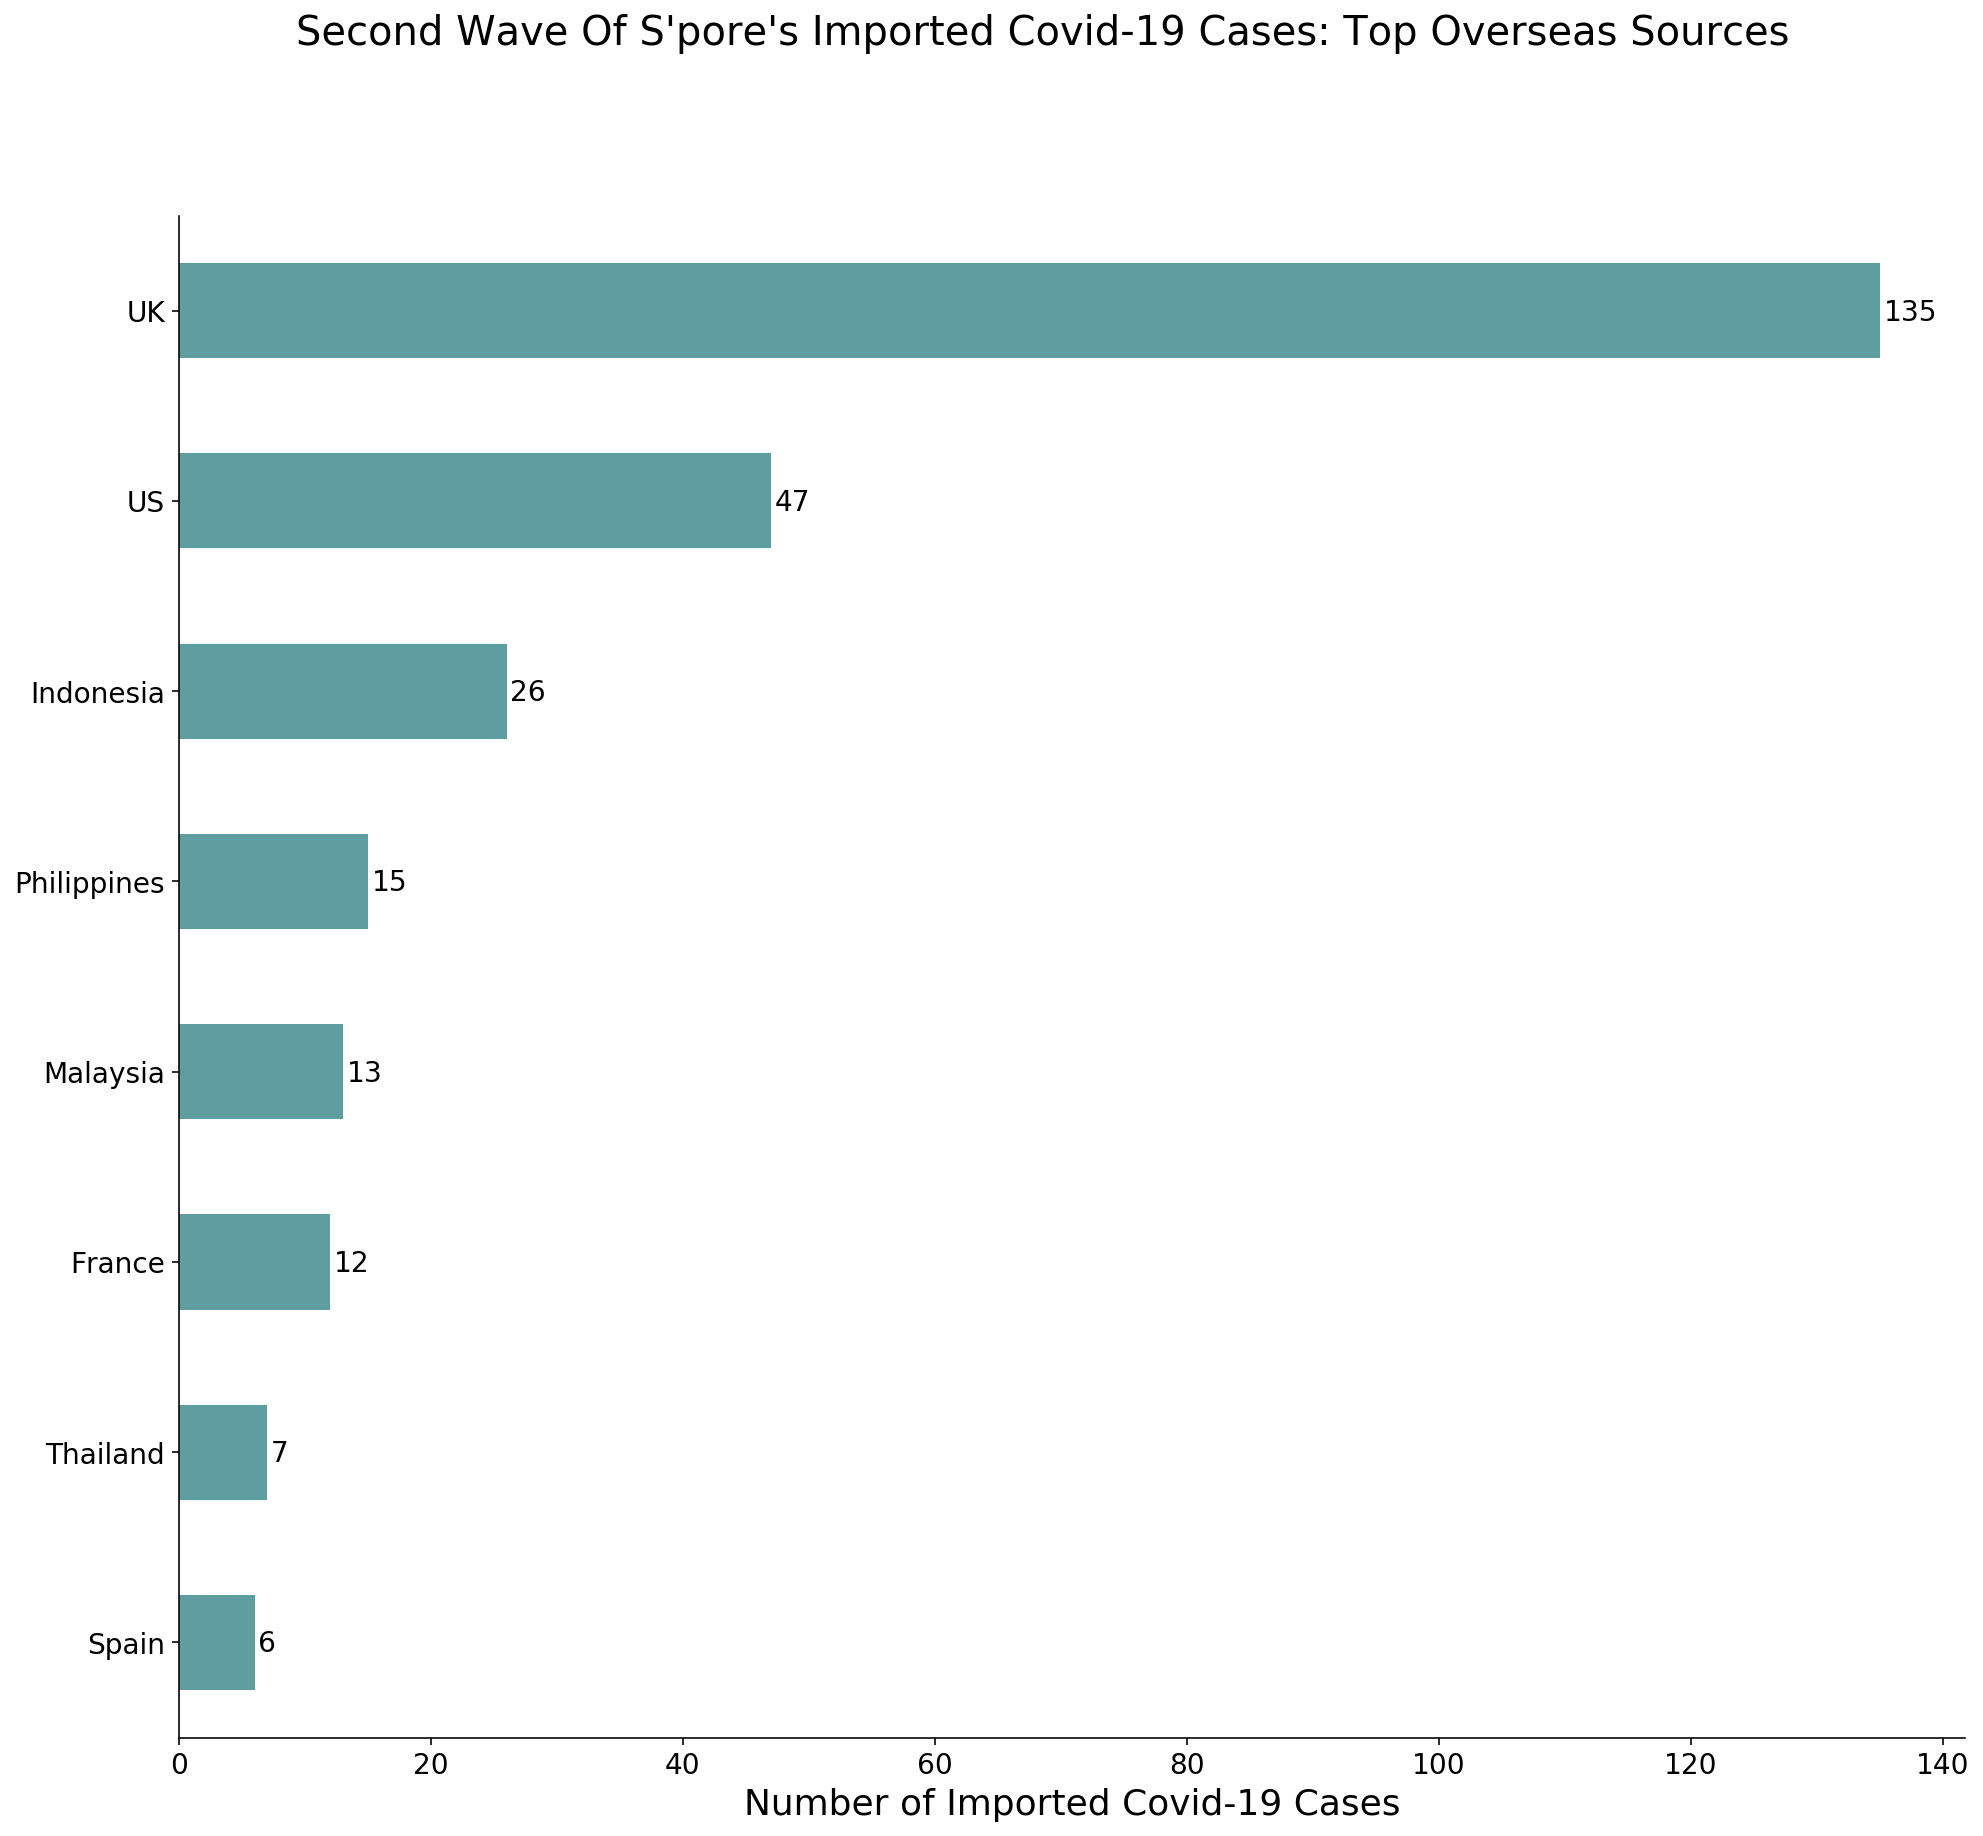

In [39]:
fig, ax = plt.subplots(figsize=(16, 14))

wave2['Travel History'].value_counts().head(8).sort_values(ascending=True).plot(
    kind="barh", color="cadetblue"
)

totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(
        i.get_width() + 0.3,
        i.get_y() + 0.2,
        str(round((i.get_width()))),
        fontsize=14,
        color="black",
    )

fig.suptitle(
    "Second Wave Of S'pore's Imported Covid-19 Cases: Top Overseas Sources", fontsize=20
)

plt.ylabel("", fontsize=18)
plt.xlabel("Number of Imported Covid-19 Cases", fontsize=18)

ax.grid(False)
sns.despine()
plt.show()

## NOTE:

* The geographic breakdown of the imported cases is striking when we split them according to the two phases of the outbreak that we've seen so far: the First Wave from January 23 to March 09, and the Second Wave from March 10 onwards.


* China, which dominated the number of imported cases in the first phase, is naturally missing from the chart in the Second Wave due to [tough travel restrictions](https://www.reuters.com/article/us-china-health-singapore/singapore-bans-china-travelers-to-keep-out-coronavirus-idUSKBN1ZU1A0) that the Singapore authorities introduced in late January against Chinese travellers and those with a recent travel history to the mainland.


* The surge in imported cases from the UK and the US appears to be mostly due to Singaporeans, particularly students, returning home in response to the poor handling of the Covid-19 outbreak in their host countries.


* The authorities expect [more of these Singaporean students and residents in the UK and US to return in the coming weeks](https://www.channelnewsasia.com/news/singapore/covid19-returning-singapore-residents-uk-us-shn-hotels-12571490), and are taking no chances. Adapting lessons learnt from the first phase of the outbreak, Singapore has mandated that residents returning from these two countries will go straight from the airport to [hotels](https://www.bloomberg.com/news/articles/2020-03-28/in-singapore-quarantine-comes-with-a-sea-view-and-room-service) to serve out a two-week quarantine.

# 5. LOCALLY TRANSMITTED CASES

* The most interesting way to examine the local cases would be to see how they are connected, via network charts. A more detailed version will have to come in another post, given the amount of work involved in mapping out the clusters.

* Here's a quick version I rustled up via Flourish's excellent survey template. You can access it [here](https://public.flourish.studio/visualisation/1722034/)

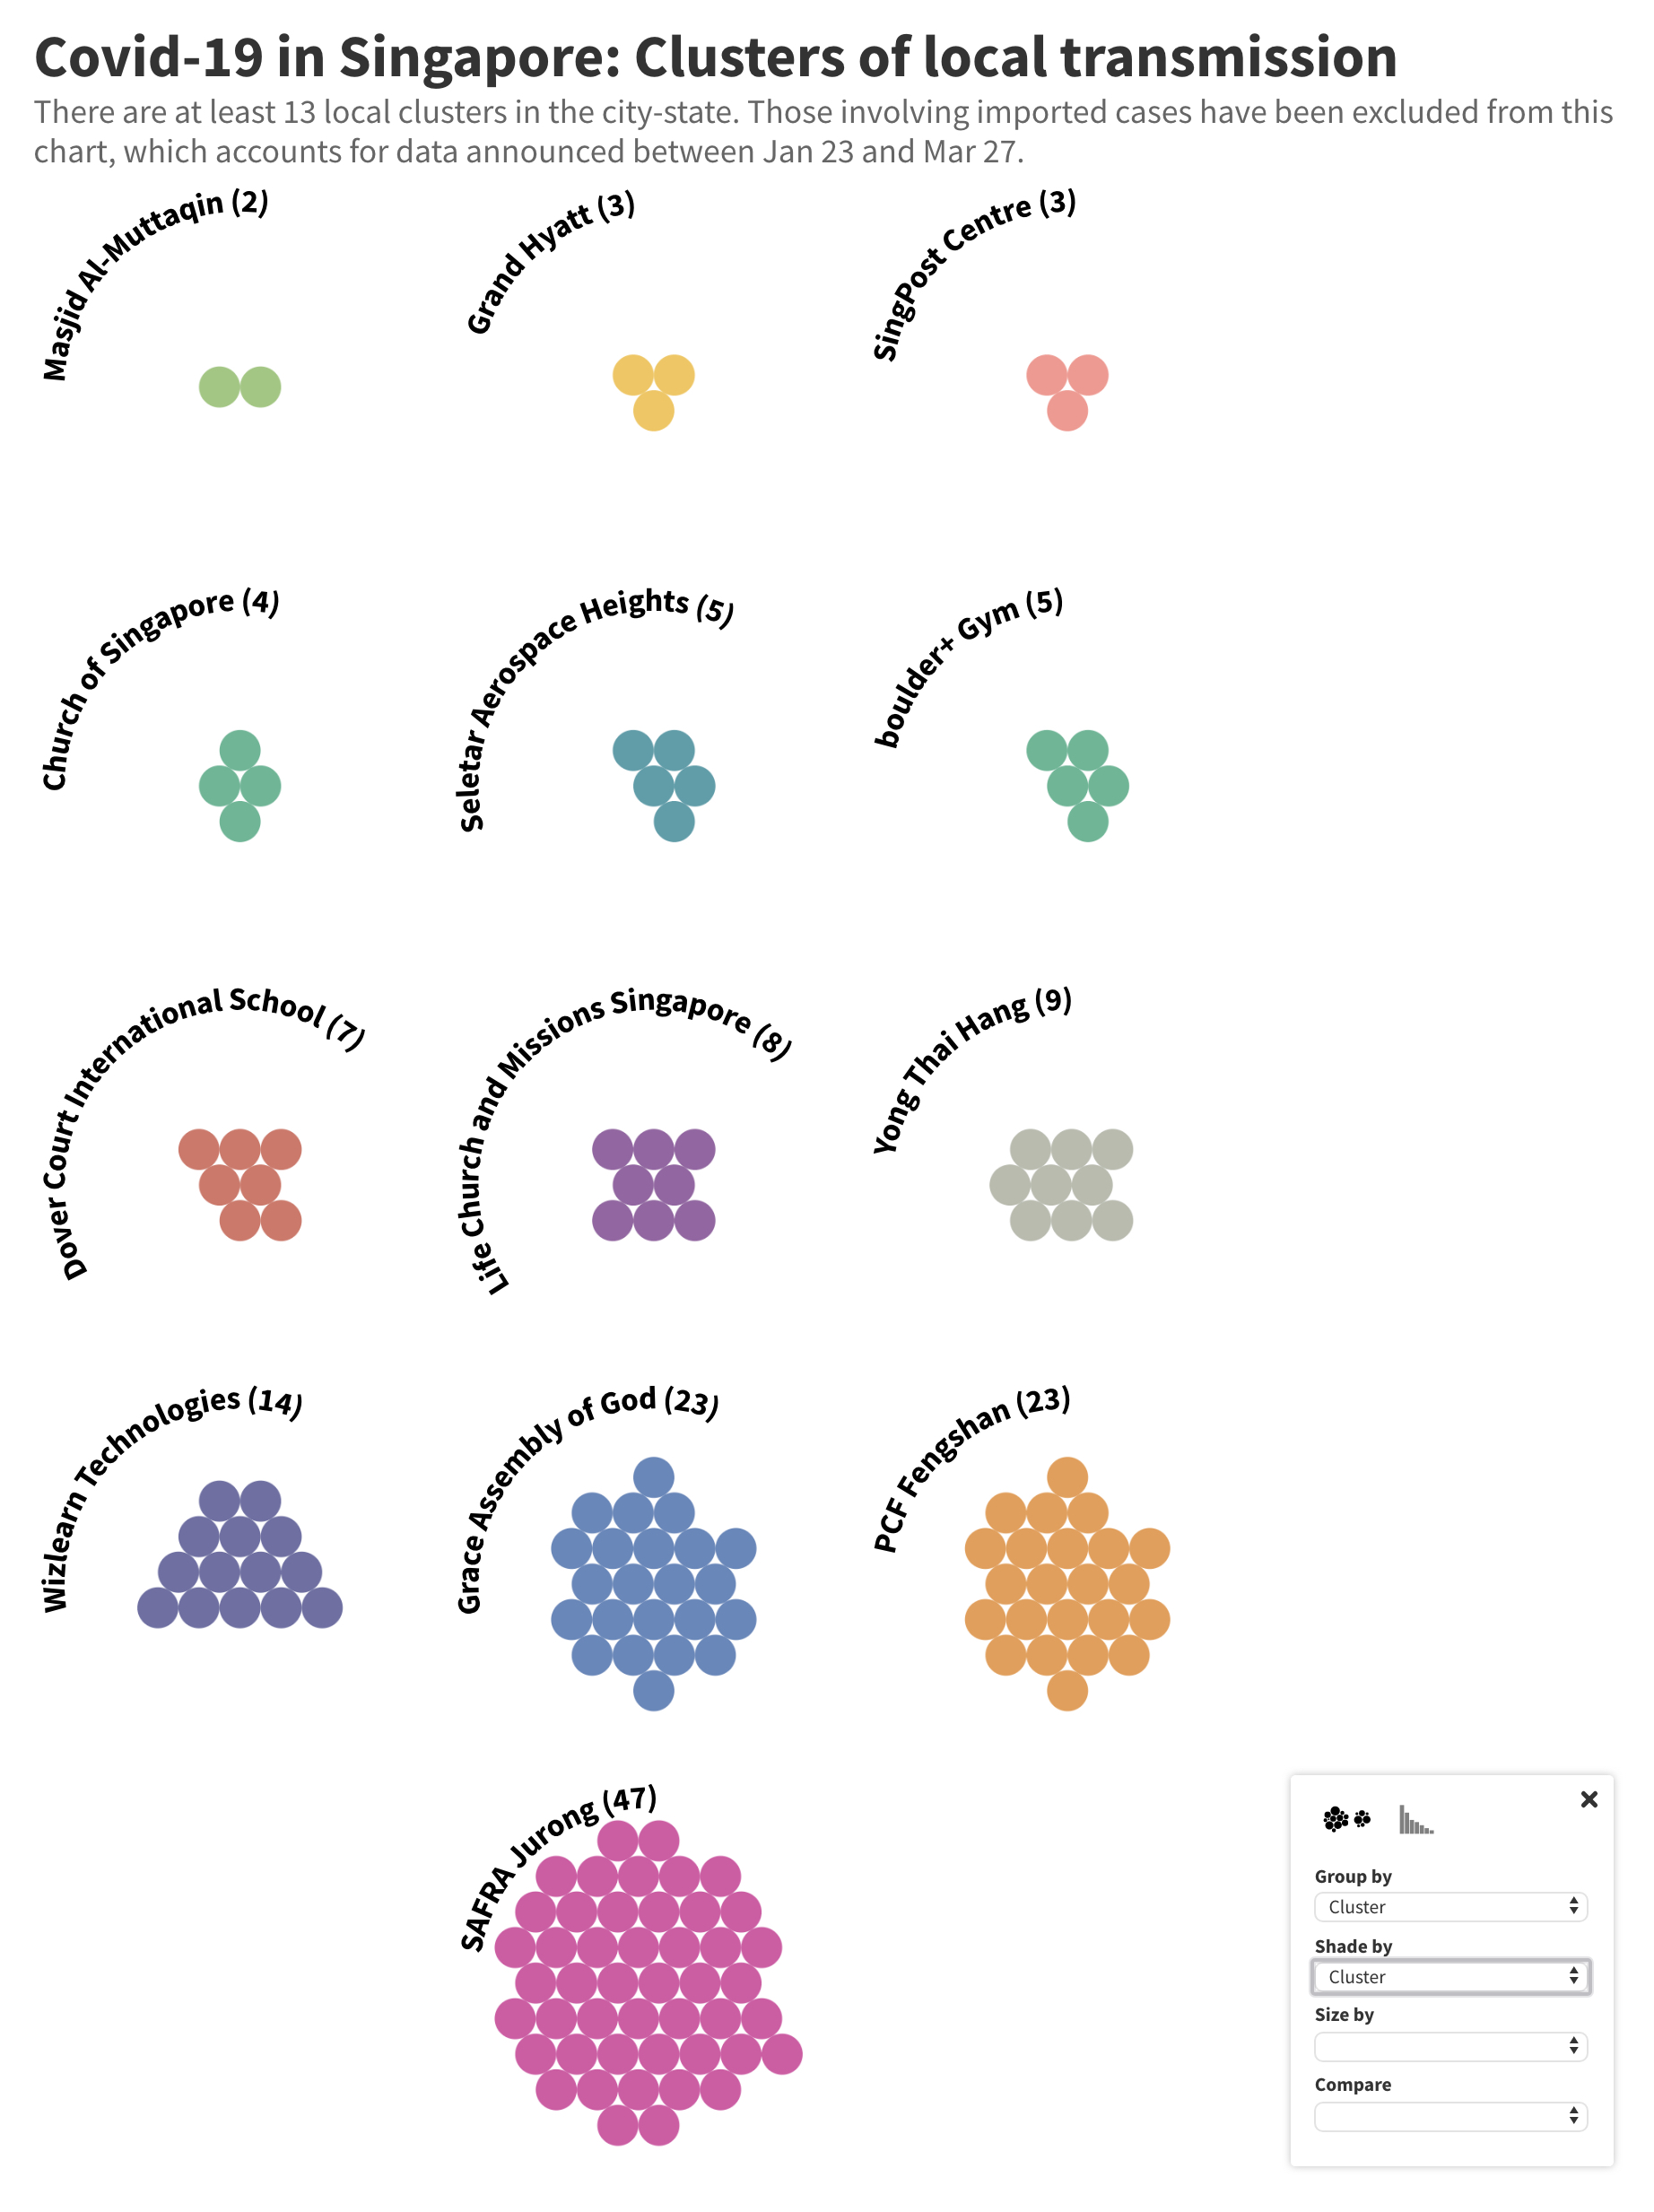

* The biggest cluster so far is the SAFRA Jurong cluster, which is linked to a dinner function on Feb 15. Many participants at the function had [common social circles](https://www.straitstimes.com/singapore/health/patients-in-safra-jurong-cluster-had-more-than-just-a-dinner-in-common) and activities that worsened the spread of the virus. 


* The chart below is useful for getting a better sense of the context of the spikes in local transmission. We essentially see the lag of a few days between the first case of a new cluster, and a subsequent spike in local cases. Singapore's situation is unlike most countries, however, given its effective contact tracing regime that aggressively tracks down connected cases.

* The spike in local cases from March 24 onwards is due to the emergence of at least 3 new clusters around the same time:
    - The PCF Fengshan cluster which has 26 cases and counting; first case emerged on March 23

    - The Dover Court International School which has at least 8 cases; first case emerged on March 24
    
    - The SingPost Centre cluster which has at least 5 cases; first case emerged on March 24

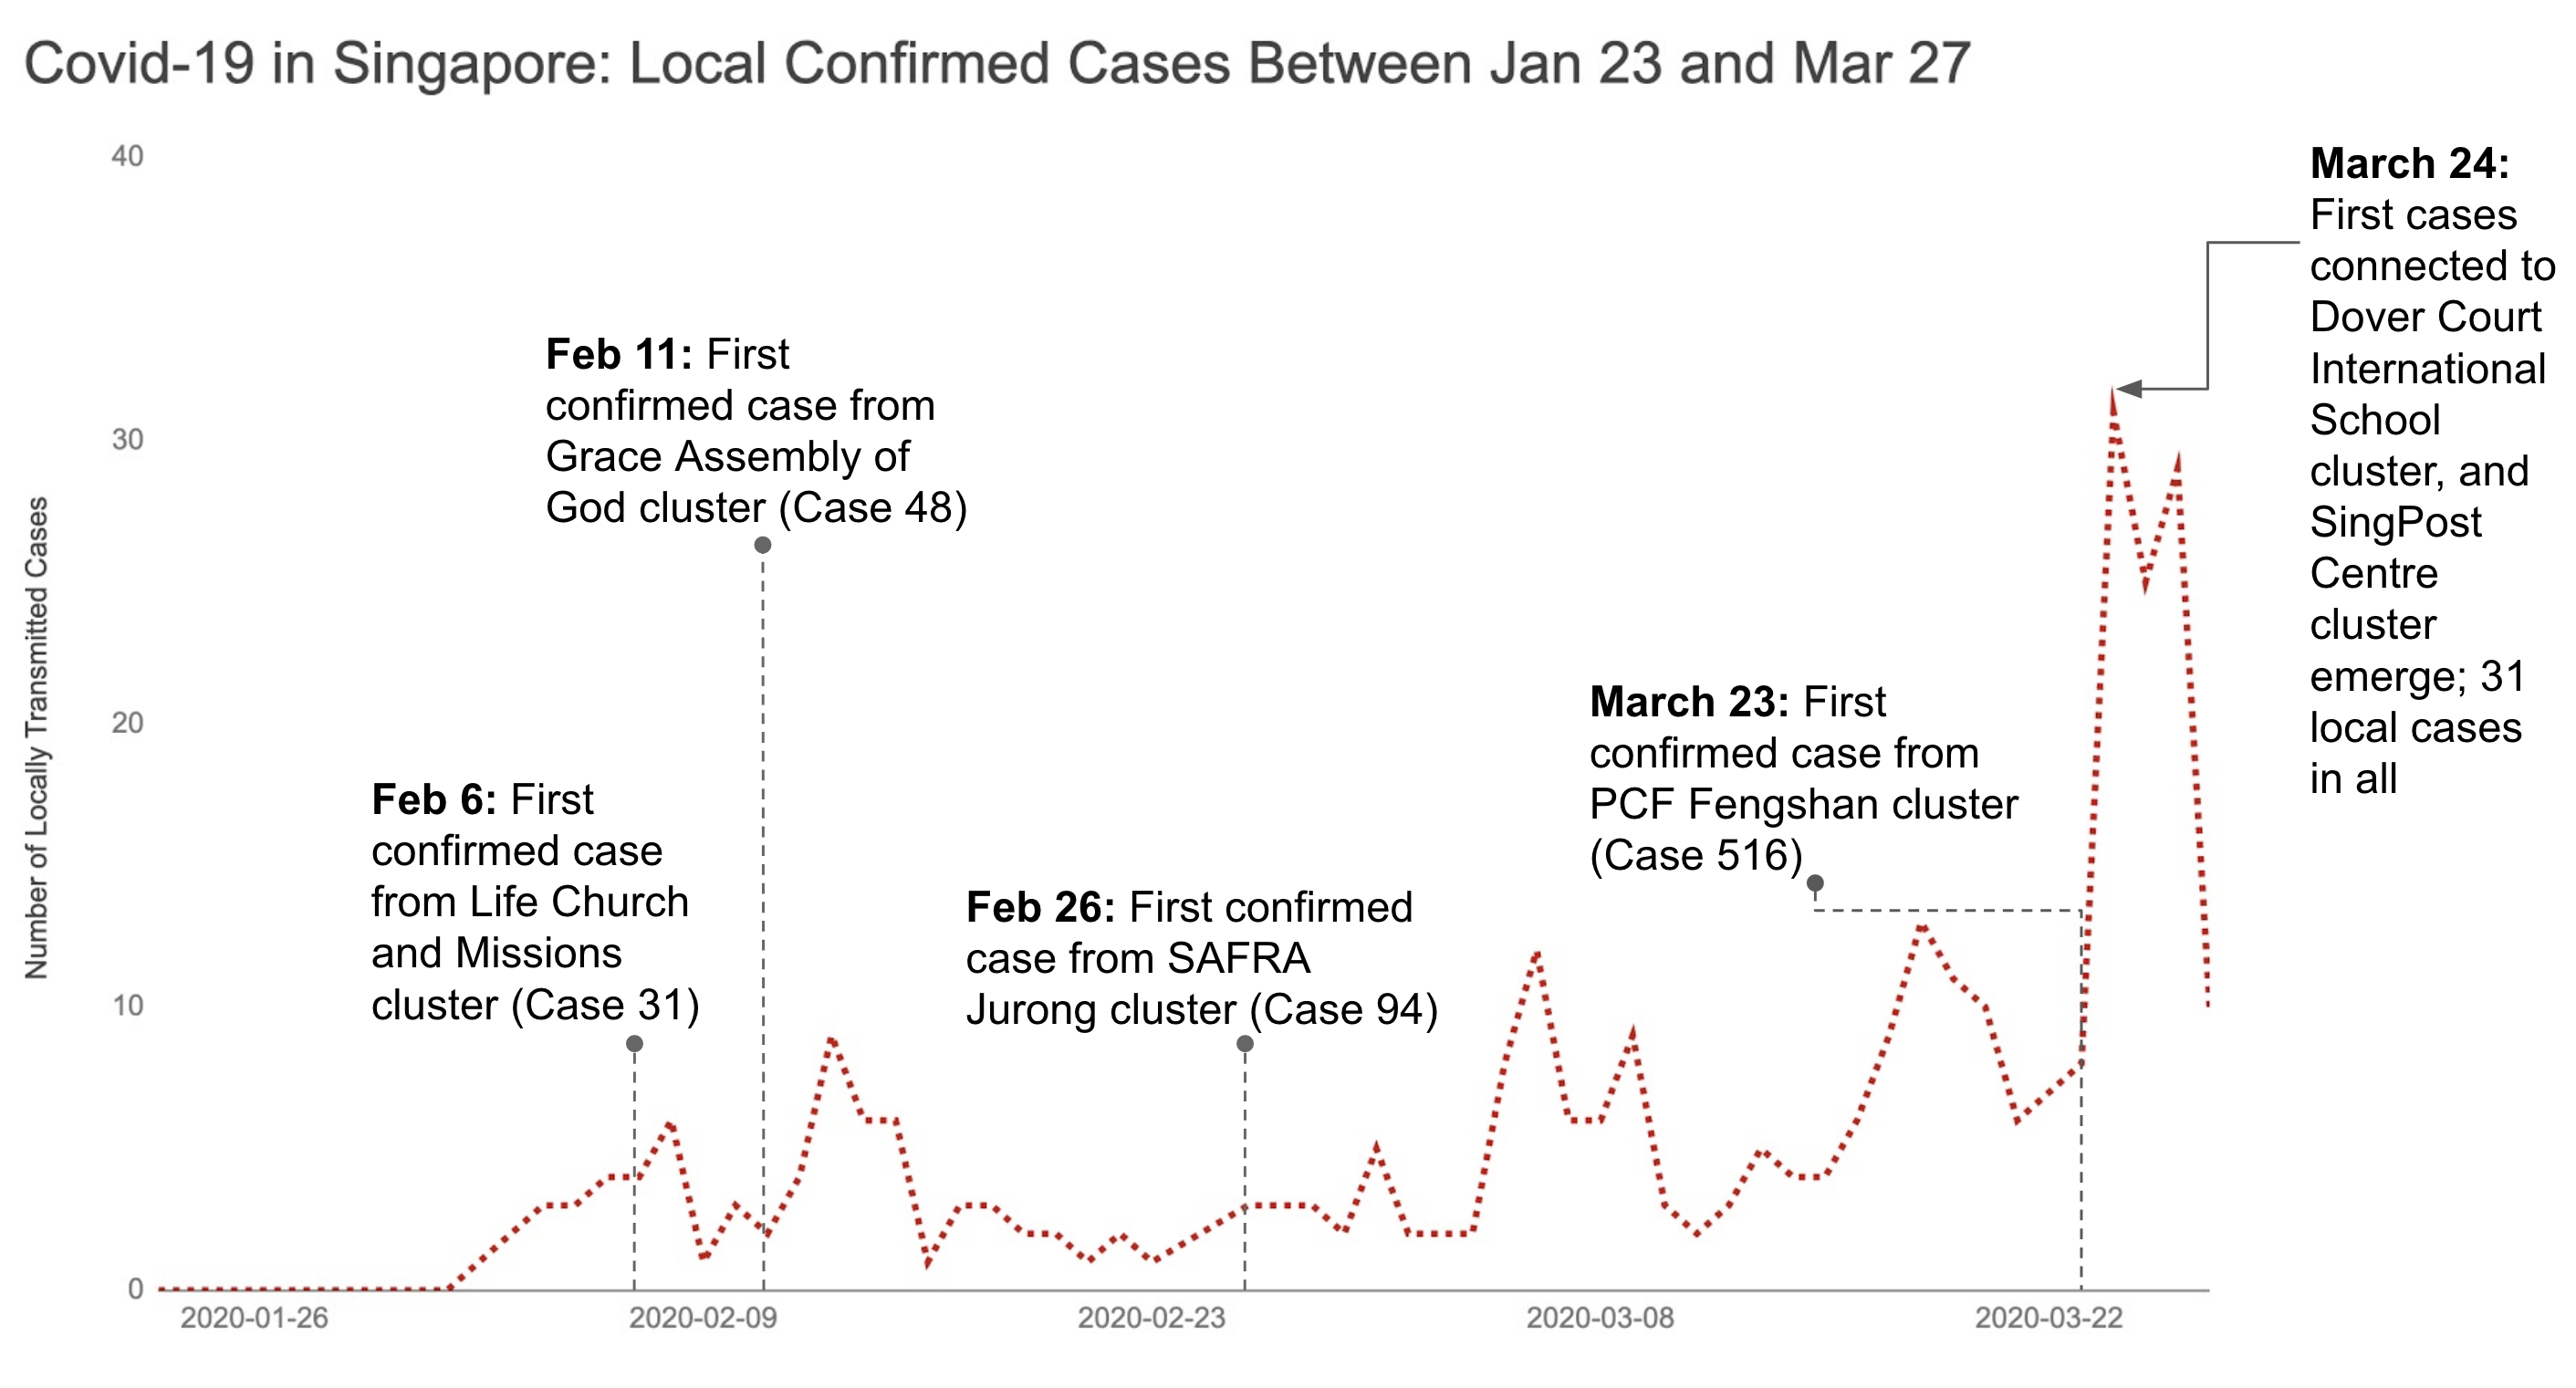

## END